# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [11]:
%cd C:\Source\food_volume_estimation

C:\Source\food_volume_estimation


In [97]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = 'models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = 'models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = 'models/segmentation/mask_rcnn_food_segmentation.h5'

In [27]:
import tensorflow as tf
print(tf.__version__)
print("TensorFlow GPU:",tf.test.is_gpu_available())

1.14.0
TensorFlow GPU: False


In [98]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False) #False
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights models/segmentation/mask_rcnn_food_segmentation.h5


[*] Creating intrinsics matrix from given FOV: 59.68
[*] Ellipse parameters: (116.49103546142578, 67.40454864501953, 90.0, 61.81818181818181, 0.2193849618428625)
[*] Found 3 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.29030629289928483, 0.049909571720132696, -0.527736534259754, -0.847940555144178]
[*] Estimated volume: 0.07099259783766676 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


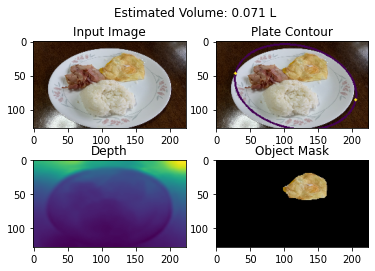

[*] Estimated plane parameters (w0,w1,w2,w3): [0.29729174357041566, -0.04353460510422893, -0.4238171931430979, -0.9047009035889845]
[*] Estimated volume: 0.06337441113237025 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


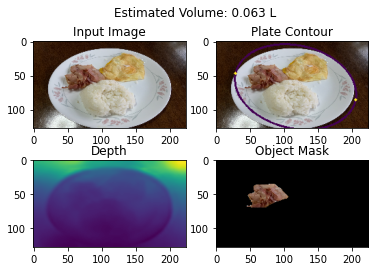

[*] Estimated plane parameters (w0,w1,w2,w3): [0.2849884367226446, 0.02081233956153456, -0.5001787633612849, -0.8656720228841585]
[*] Estimated volume: 0.12600937384668445 L


C:\Source\food_volume_estimation\food_volume_estimation\point_cloud_utils.py:163: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(rows + cols + str(r + 1))


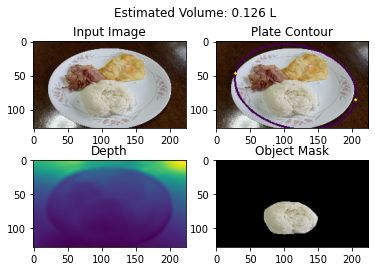

0.26037638281672143

In [99]:
%matplotlib inline

# Estimate volumes in input image
input_image = 'images/IMG_0972.JPG'
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=59.680, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)
sum([output[0] for output in outputs_list])*1000

In [79]:
def predict_one(input_image):
    plate_diameter = 0 # Set as 0 to ignore plate detection and scaling
    outputs_list = estimator.estimate_volume(input_image, fov=59.680, plate_diameter_prior=plate_diameter, 
                                             plot_results=False)
    return outputs_list

In [49]:
fruitroot = "G:\\My Drive\\Colab Notebooks\\ECUSTFD-resized-\\"
path_img = 'JPEGImages'

In [58]:
import pandas as pd
import os

In [ ]:
df_img = pd.DataFrame(columns=['id', 'subid', 'type','side','fname'])
df_vol = pd.read_excel(fruitroot + 'density.xls', sheet_name=None)

In [62]:
name_dict = {name[:name.index('(')]:name for name in os.listdir(fruitroot + path_img)}

In [77]:
output_list = predict_one(fruitroot+path_img+'\\'+'orange010T(13).JPG')
sum(output_list)*1000

[*] Creating intrinsics matrix from given FOV: 70
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.


0.21555768256004598

In [82]:
res_dict = dict()
for name,fname in name_dict.items():
    res = predict_one(fruitroot+path_img+'\\'+fname)
    print(name, fname, sum(res)*1000)
    res_dict[name] = res

[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange010T orange010T(13).JPG 0.14488746546269904
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange011S orange011S(9).JPG 0.06343089797812587
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange011T orange011T(9).JPG 0.11435579122190483
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange012S orange012S(9).JPG 0.15222127566432156
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange012T orange012T(9).JPG 0.06479917448156423
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange013S orange013S(5).JPG 0.07219694552716201
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange013T orange013T(5).JPG 0.05804400100668766
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange014S orange014S(3).JPG 0.05859508103176285
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange014T orange014T(3).JPG 0.06208751537222652
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse 

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  ax = math.sqrt((x0 ** 2 * n ** 2 + y0 ** 2) / (n ** 2 * (k ** 2 + 1)))
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  v = (x * c + y * s) ** 2 / a ** 2 + (-x * s + y * c) ** 2 / b ** 2
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  dist[3] = abs(float(ellipse1.minor_len - ellipse2.minor_len)) / min(ellipse1.minor_len, ellipse2.minor_len)  # Distance of b
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:43: RuntimeWarning: invalid value encountered in double_scalars
  r1 = ellipse1.minor_len / ellipse1.major_len


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange015T orange015T(6).JPG 0.05847850384611883
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
peach001S peach001S(9).JPG 0.029837734639486038
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
peach001T peach001T(9).JPG 0.03250178703227781
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
peach002S peach002S(8).JPG 0.030839655186289176
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
peach002T peach002T(8).JPG 0.015426195454020597
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  ax = math.sqrt((x0 ** 2 * n ** 2 + y0 ** 2) / (n ** 2 * (k ** 2 + 1)))
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  v = (x * c + y * s) ** 2 / a ** 2 + (-x * s + y * c) ** 2 / b ** 2
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  dist[3] = abs(float(ellipse1.minor_len - ellipse2.minor_len)) / min(ellipse1.minor_len, ellipse2.minor_len)  # Distance of b
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:43: RuntimeWarning: invalid value encountered in double_scalars
  r1 = ellipse1.minor_len / ellipse1.major_len
C:\Source\food_volume_estimation\food_volume_estimation\elli

[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear003T pear003T(9).JPG 0.10803276838574055
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear004S pear004S(9).JPG 0.053959418972214665
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear004T pear004T(9).JPG 0.06345915932293009
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear005S pear005S(7).JPG 0.10748244491527024
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear005T pear005T(7).JPG 0.0918333330809425
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear006S pear006S(9).JPG 0.20203868327153876
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
pear006T pear006T(9).JPG 0.11612574419992922
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with e

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
qiwi002T qiwi002T(3).JPG 0.2807403587260203
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
qiwi003S qiwi003S(4).JPG 0.10218098216253191
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
qiwi003T qiwi003T(4).JPG 0.046133849772874526
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
qiwi004S qiwi004S(8).JPG 0.056208228687792704
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
qiwi004T qiwi004T(8).JPG 0.10019451687402235
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
tomato004T tomato004T(9).JPG 0.07347116516147222
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist002T fired_dough_twist002T(5).JPG 0.03650570218652168
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist003S fired_dough_twist003S(9).JPG 0.047502375471539154
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist003T fired_dough_twist003T(9).JPG 0.09327597695477974
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist004S fired_dough_twist004S(9).JPG 0.0316592999271738
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist004T fired_dough_twist004T(9).JPG 0.05124006190043154
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist005S fired_dough_twist005S(9).JPG 0.02770318432864687
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
fired_dough_twist005T fired_do

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
lemon001T lemon001T(9).JPG 0.058373925440717005
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
lemon002S lemon002S(9).JPG 0.02781039794540631
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
lemon002T lemon002T(9).JPG 0.04864650744567818
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
lemon003S lemon003S(9).JPG 0.027227294471265345
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
lemon003T lemon003T(9).JPG 0.040260484233133435
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. 

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango001T mango001T(8).JPG 0.04977896701277246
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango002S mango002S(9).JPG 0.05397497943164952
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango002T mango002T(9).JPG 0.04758474641973618
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango003S mango003S(9).JPG 0.1008211724377321
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango003T mango003T(9).JPG 0.04400973559288461
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scal

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: invalid value encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango006T mango006T(9).JPG 0.03132470704480673
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango007S mango007S(9).JPG 0.025570515579951894
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango007T mango007T(9).JPG 0.04508405467114268
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango008S mango008S(8).JPG 0.05340692998969462
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mango008T mango008T(8).JPG 0.030590006965008455
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. S

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix005T mix005T(6).JPG 0.32871789051325145
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix006S mix006S(4).JPG 0.05219968446927345
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix006T mix006T(4).JPG 0.22079141575459751
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix007S mix007S(5).JPG 0.04506790970362007
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix007T mix007T(5).JPG 0.2897793663983602
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected me

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix008T mix008T(4).JPG 0.1106451080510557
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix009S mix009S(4).JPG 0.10460907993650051
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix009T mix009T(4).JPG 0.1184872768955896
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix010S mix010S(6).JPG 0.06570926584125068
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix010T mix010T(7).JPG 0.11090679860511667
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix011S mix011S(4).JPG 0.14411030711421483
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 2 food object(s) in image.
mix011T mix011T(4).JPG 0.13881187810383977
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected me

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mooncake005T mooncake005T(7).JPG 0.0688581581890344
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mooncake006S mooncake006S(8).JPG 0.007186810685035481
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: invalid value encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
mooncake006T mooncake006T(8).JPG 0.07770031977793507
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange001S orange001S(2).JPG 0.1843116595527296
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange001T orange001T(4).JPG 0.058813777084231404
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange002S orange002S(4).JPG 0.21285623558152225
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange002T orange002T(2).JPG 0.2267452665770505
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange003S orange003S(8).JPG 0.2575337952973709
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange003T orange003T(8).JPG 0.17958002435976717
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange004S orange004S(4).JPG 0.28569471819730907
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange004T orange004T(4).JPG 0.14315293814853658
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse fo

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange007T orange007T(8).JPG 0.09223056101356203
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange008S orange008S(9).JPG 0.053221678070983845
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange008T orange008T(9).JPG 0.09814727413410711
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange009S orange009S(9).JPG 0.05782371555661897
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: invalid value encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange009T orange009T(9).JPG 0.04464278123903197
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
orange010S orange010S(9).JPG 0.07475769953193175
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple001S apple001S(2).JPG 0.0636594970716678
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple001T apple001T(2).JPG 0.08634554092376273
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple002S apple002S(8).JPG 0.12122305387371198
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple002T apple002T(6).JPG 0.10599461064432325
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple003S apple003S(6).JPG 0.14961303118013394
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple003T apple003T(2).JPG 0.11630349746129928
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple004S apple004S(4).JPG 0.1825752846064204
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple004T apple004T(3).JPG 0.2471295783001691
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scali

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple007T apple007T(4).JPG 0.126657383233323
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple008S apple008S(4).JPG 0.16837975151331122
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple008T apple008T(4).JPG 0.09113853010645509
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple009S apple009S(4).JPG 0.13582775320353238
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple009T apple009T(4).JPG 0.11553182867562088
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple010S apple010S(4).JPG 0.13445455504185744
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple010T apple010T(4).JPG 0.06252400059374535
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple011S apple011S(5).JPG 0.09098365591377523
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple011T apple011T(5).JPG 0.08776764291817152
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple012S apple012S(4).JPG 0.1626707950732123
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple012T apple012T(5).JPG 0.05304876120894133
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple013S apple013S(8).JPG 0.06045733622066992
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple013T apple013T(8).JPG 0.055978217968098654
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Sca

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple016T apple016T(9).JPG 0.16090953507631242
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple017S apple017S(9).JPG 0.054783226206397535
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple017T apple017T(9).JPG 0.11563307585970142
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple018S apple018S(9).JPG 0.14120281590718972
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple018T apple018T(9).JPG 0.14358363871517862
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple019S apple019S(7).JPG 0.3274231055604677
[*] Creating intrinsics matrix from given FOV: 59.68


C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  v = ((q1 - k_plus) * (q2 - k_plus) / ((1 + q1 * k_plus) * (1 + q2 * k_plus)))
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:68: RuntimeWarning: invalid value encountered in double_scalars
  beta = (q3 * q4 + 1) * (q1 + q2) - (q1 * q2 + 1) * (q3 + q4)


[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
apple019T apple019T(7).JPG 0.12104410891915496
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana001S banana001S(3).JPG 0.06973647503122844
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana001T banana001T(4).JPG 0.03540551588379491
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana002S banana002S(3).JPG 0.1292279264843767
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana002T banana002T(3).JPG 0.6367661481078349
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse foun

C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_estimator.py:69: RuntimeWarning: invalid value encountered in double_scalars
  k_plus = (-beta + math.sqrt(beta ** 2 + 4 * alpha ** 2)) / (2 * alpha)
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  v = (x * c + y * s) ** 2 / a ** 2 + (-x * s + y * c) ** 2 / b ** 2
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  dist[3] = abs(float(ellipse1.minor_len - ellipse2.minor_len)) / min(ellipse1.minor_len, ellipse2.minor_len)  # Distance of b
C:\Source\food_volume_estimation\food_volume_estimation\ellipse_detection\ellipse_merger.py:43: RuntimeWarning: invalid value encountered in double_scalars
  r1 = ellipse1.minor_len / ellipse1.major_len
C:\Source\food_volume_estimation\food_volume_estimation\ellips

[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana009T banana009T(8).JPG 0.20244238553334995
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana010S banana010S(8).JPG 0.20591370825552494
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana010T banana010T(8).JPG 0.07754655835702567
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 0 food object(s) in image.
banana011S banana011S(9).JPG 0
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with expected median depth.
[*] Found 1 food object(s) in image.
banana011T banana011T(9).JPG 0.1672909539057463
[*] Creating intrinsics matrix from given FOV: 59.68
[*] No ellipse found. Scaling with

KeyboardInterrupt: 

In [84]:
len(res_dict)

286

In [91]:
res_dict

{'orange010T': [0.00014488746546269905],
 'orange011S': [6.343089797812587e-05],
 'orange011T': [0.00011435579122190482],
 'orange012S': [0.00015222127566432155],
 'orange012T': [6.479917448156423e-05],
 'orange013S': [7.2196945527162e-05],
 'orange013T': [5.804400100668766e-05],
 'orange014S': [5.859508103176285e-05],
 'orange014T': [6.208751537222652e-05],
 'orange015S': [0.00017612113643062323],
 'orange015T': [5.847850384611883e-05],
 'peach001S': [2.9837734639486037e-05],
 'peach001T': [3.250178703227781e-05],
 'peach002S': [3.0839655186289175e-05],
 'peach002T': [1.5426195454020598e-05],
 'peach003S': [4.932180153840426e-05],
 'peach003T': [2.4569725624736016e-05],
 'peach004S': [2.48307829325635e-05],
 'peach004T': [2.331224747847121e-05],
 'peach005S': [2.9214888629850207e-05],
 'peach005T': [8.603392092929007e-05],
 'pear001S': [7.372339361645464e-05],
 'pear001T': [0.0001549056727071139],
 'pear002S': [7.334253585157222e-05],
 'pear002T': [5.125851337959148e-05],
 'pear003S':

In [93]:
pddict = {'example':[], 'volume':[]}
for k,v in res_dict.items():
    pddict['example'].append(k)
    pddict['volume'].append(0 if not len(v) else v[0]*1000)

In [96]:
pd.DataFrame(pddict).to_csv('ECUSTDF.csv')

In [87]:
df_vol = pd.read_excel(fruitroot + 'density.xls', sheet_name=None)

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [40]:
%matplotlib widget
# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …